In [1]:
import tensorflow as tf
import utils as u
import h5py
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import os
import numpy as np
import random as rn


from sklearn.metrics import roc_curve,roc_auc_score,auc
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn import metrics

%matplotlib inline
import itertools

import keras 
from keras.models import load_model
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras import backend as K
from keras.layers import Dense, Dropout, Flatten,Conv2D, MaxPooling2D,Activation,BatchNormalization,LeakyReLU
from keras.utils import to_categorical,plot_model
from keras.models import Sequential
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
#for reproducibility in Python,numpy and Tensorflow we set their respective seeds as follows
os.environ['PYTHONHASHSEED']='0'
np.random.seed(None) ##don't want to seed numpy with random sized hot/dead regions
rn.seed(2)
tf.set_random_seed(3)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

#Force Tensorflow to use a single thread (this is recommended because it might be a cause of randomness)
sess=tf.Session(graph=tf.get_default_graph(),config=session_conf)
K.set_session(sess)

In [3]:
data_folder = '../../data'
file_name = 'HCAL_digi+rechit_occ.hdf5'
group = 'DigiTask_Occupancy_depth_depth1'

runs = ['306459','306138','306139']

data_sample= np.empty([0,72,84])
for run in runs:
    input_file=h5py.File(data_folder+'/'+'HCAL_digi+rechit_occ_run'+run+'.hdf5','r+')
    data_sample = np.concatenate((data_sample,np.array(input_file[group])),axis=0)
    
print data_sample.shape

data_sample=data_sample[:,:,26:58]

print data_sample.shape

average_occ = np.average(data_sample)

print average_occ

for i in range(data_sample.shape[0]):
    for j in range(data_sample.shape[1]):
        for k in range(data_sample.shape[2]):
            if data_sample[i][j][k] == 0.0:
                #print 'yo', i, j, k
                data_sample[i][j][k] = average_occ
                

(2997, 72, 84)
(2997, 72, 32)
567.190321398


Shape of regular image is:  (2997, 72, 32)
Shape of dead image is:  (2997, 72, 32)
Shape of hot image is:  (0,)



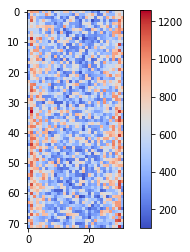

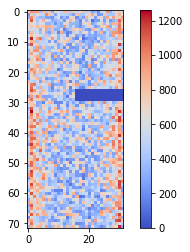

In [4]:
input_images=data_sample[:]
hotregion_image=[]
deadregion_image=[]

for k in input_images:
    
    xLen = 16
    yLen = 4
    
    a = 2+4*np.random.randint(18)
    b = 16*np.random.randint(2)
    
    if a == 70:
        xdim=(b,b+16)
        ydim=(a,a+2)
        top = u.killRBX(k,xdim,ydim)
        xdim=(b,b+16)
        ydim=(0,2)
        deadregion_image.append(u.killRBX(top,xdim,ydim))
        
    else:
        xdim=(b,b+xLen)
        ydim=(a,a+yLen)
        deadregion_image.append(u.killRBX(k,xdim,ydim))
    
hotregion_image=np.array(hotregion_image)
deadregion_image=np.array(deadregion_image)

print "Shape of regular image is: ",input_images.shape
print "Shape of dead image is: " ,deadregion_image.shape
print "Shape of hot image is: " ,hotregion_image.shape

print ''
im=plt.imshow(input_images[1],cmap=cm.coolwarm)
plt.colorbar()
plt.show()
plt.clf()


im=plt.imshow(deadregion_image[1],cmap=cm.coolwarm)
plt.colorbar()
plt.show()
plt.clf()#plt.clf clears the figure and it's axis but leaves the window open. 
         #as opposed to plt.close which closes the window. If you are showing many images at a time without
         #closing the window it is better.

#input_image=np.reshape(input_image,(input_image.shape[0],input_image.shape[1]))


In [6]:
sample= np.append(data_sample,deadregion_image,axis=0)
print sample.shape

(5994, 72, 32)


In [7]:
X=np.copy(sample)

y=np.zeros((sample.shape[0],1))
k=0
for img in X:
    X[k] = X[k] / np.max(img)
    k=k+1
#print y.shape
#print input_images.shape[0]


#this is because I am only going to add the hot and dead region images

### Changed this to a 2 class problem, good and bad
y[-1*input_images.shape[0]:]=1
#if you want it as integers leave this as it is
#if you would like it as a vector then do this

y=to_categorical(y,2)

# convert class vectors to binary class matrices
#y_train = keras.utils.to_categorical(y_train, num_classes)
#y_test = keras.utils.to_categorical(y_test, num_classes)

print "X shape is: ",X.shape
print "y shape is: ",y.shape
# input image dimensions
img_rows, img_cols = X.shape[1],X.shape[2]

X shape is:  (5994, 72, 32)
y shape is:  (5994, 2)


Xtrain.shape (3596, 72, 32)
Xtest.shape (2398, 72, 32)
ytrain.shape (3596, 2)
ytest.shape (2398, 2)
Printing labels and their corresponding images
-------------------
[ 0.  1.]


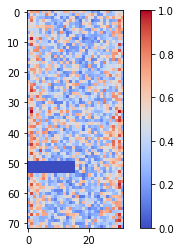

-------------------
[ 0.  1.]


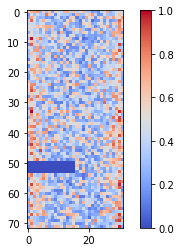

-------------------
[ 0.  1.]


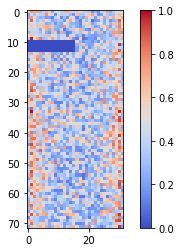

-------------------
[ 0.  1.]


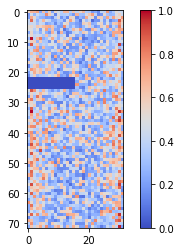

-------------------
[ 0.  1.]


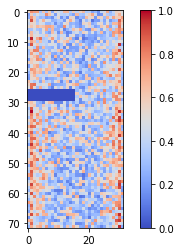

-------------------
[ 1.  0.]


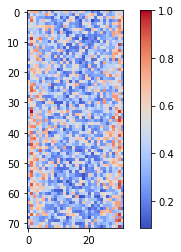

-------------------
[ 0.  1.]


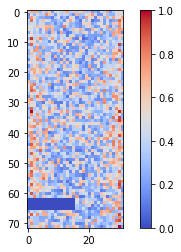

-------------------
[ 1.  0.]


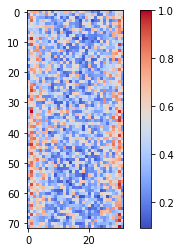

-------------------
[ 0.  1.]


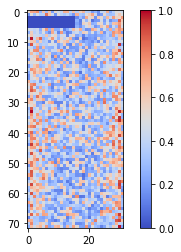

-------------------
[ 0.  1.]


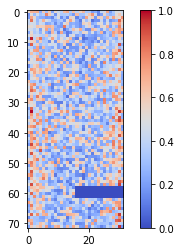

Xtrain.shape after if statement (3596, 72, 32, 1)
Xtest.shape after if statement (2398, 72, 32, 1)
ytrain.shape after if statement (3596, 2)
ytest.shape after if statement (2398, 2)


In [8]:
Xtrain, Xtest ,ytrain, ytest =train_test_split(X,y,test_size=.4,random_state =5 )

print 'Xtrain.shape',Xtrain.shape
print 'Xtest.shape',Xtest.shape
print 'ytrain.shape',ytrain.shape
print 'ytest.shape',ytest.shape
print 'Printing labels and their corresponding images'
    
for k in range(10):
    print'-------------------'
    print ytrain[k]
    im=plt.imshow(Xtrain[k],cmap=cm.coolwarm)
    plt.colorbar()
    plt.show()
    plt.clf()


Xtrain, Xtest,input_shape= u.check_test_and_train_images_format(Xtrain, Xtest, img_rows, img_cols)

print 'Xtrain.shape after if statement',Xtrain.shape
print 'Xtest.shape after if statement',Xtest.shape
print 'ytrain.shape after if statement',ytrain.shape
print 'ytest.shape after if statement',ytest.shape
    

In [9]:
"""A Custom Loss Function"""

#### [0.1,0.9] works well (acc > 0.99) but still no movement across the diagonal

x = np.array([[0.1,0.9]])
w = K.variable(x, name='w')

def customLoss(yTrue,yPred):
    return K.sum(K.dot(w, K.transpose(K.square(yTrue - yPred))))

In [10]:
"""this is the dummy model"""
#model = Sequential()

#model.add(Conv2D(10, kernel_size=(2, 2), strides=(1, 1),input_shape=input_shape))
#model.add(BatchNormalization())
#model.add(Activation('relu'))
#model.add(MaxPooling2D(pool_size=(2,2)))

#model.add(Conv2D(8, kernel_size=(3, 3),strides=(1, 1)))
#model.add(BatchNormalization())
#model.add(Activation('relu'))
#model.add(MaxPooling2D(pool_size=(2,2)))

#model.add(Conv2D(8,kernel_size=(1,1)))
#model.add(BatchNormalization())
#model.add(Activation('relu'))
#
#model.add(Dropout(0.25))
#model.add(Flatten())

#model.add(Dense(8))
#model.add(BatchNormalization())
#model.add(Activation('relu'))

##Last layer is Dense (as usual), note output size (first arg) is label size
#model.add(Dense(2, activation='softmax'))


#model.compile(loss='categorical_crossentropy',
#              optimizer='Nadam',#Adam(lr=1e-3),
#              metrics=['accuracy'])
#model.summary()
#plot_model(model, to_file='Supervised_model.png',)
#
#model.save('emptymodel.hdf5')

"""This is a more minimal model"""

model = Sequential()

model.add(Conv2D(5, kernel_size=(3, 3), strides=(1, 1),input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3,3)))

model.add(Dropout(0.25))
model.add(Flatten())

#Last layer is Dense (as usual), note output size (first arg) is label size
model.add(Dense(2, activation='softmax'))


model.compile(loss=customLoss,
              optimizer='Nadam',#Adam(lr=1e-3),
              metrics=['accuracy'])

model.summary()
plot_model(model, to_file='Supervised_model.png',)

model.save('emptymodel.hdf5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 70, 30, 5)         50        
_________________________________________________________________
batch_normalization_1 (Batch (None, 70, 30, 5)         20        
_________________________________________________________________
activation_1 (Activation)    (None, 70, 30, 5)         0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 10, 5)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 23, 10, 5)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1150)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2302      
Total para

In [11]:
checkpointer = ModelCheckpoint(filepath='best_nbmodel_good_bad.hdf5', verbose=2, save_best_only=True)
earlystop= EarlyStopping(monitor='val_loss', min_delta=0, patience=50, verbose=1, mode='auto')

In [12]:
history = model.fit(Xtrain,ytrain,epochs=400
                    ,verbose=2
                    ,validation_data=(Xtest,ytest)
                    ,shuffle=True
                    ,callbacks=[checkpointer,earlystop])

Train on 3596 samples, validate on 2398 samples
Epoch 1/400
Epoch 00001: val_loss improved from inf to 11.02558, saving model to best_nbmodel_good_bad.hdf5
 - 26s - loss: 10.5909 - acc: 0.5715 - val_loss: 11.0256 - val_acc: 0.5063
Epoch 2/400
Epoch 00002: val_loss improved from 11.02558 to 5.64347, saving model to best_nbmodel_good_bad.hdf5
 - 26s - loss: 5.1346 - acc: 0.7709 - val_loss: 5.6435 - val_acc: 0.6514
Epoch 3/400
Epoch 00003: val_loss improved from 5.64347 to 1.13167, saving model to best_nbmodel_good_bad.hdf5
 - 25s - loss: 2.2721 - acc: 0.9049 - val_loss: 1.1317 - val_acc: 0.9858
Epoch 4/400
Epoch 00004: val_loss improved from 1.13167 to 0.39347, saving model to best_nbmodel_good_bad.hdf5
 - 26s - loss: 1.2296 - acc: 0.9569 - val_loss: 0.3935 - val_acc: 0.9992
Epoch 5/400
Epoch 00005: val_loss improved from 0.39347 to 0.18488, saving model to best_nbmodel_good_bad.hdf5
 - 27s - loss: 0.7817 - acc: 0.9761 - val_loss: 0.1849 - val_acc: 0.9992
Epoch 6/400
Epoch 00006: val_los

Epoch 59/400
Epoch 00059: val_loss did not improve
 - 25s - loss: 0.0974 - acc: 0.9969 - val_loss: 0.0277 - val_acc: 0.9992
Epoch 60/400
Epoch 00060: val_loss did not improve
 - 25s - loss: 0.1087 - acc: 0.9967 - val_loss: 0.0269 - val_acc: 0.9992
Epoch 61/400
Epoch 00061: val_loss did not improve
 - 24s - loss: 0.0989 - acc: 0.9967 - val_loss: 0.1145 - val_acc: 0.9992
Epoch 62/400
Epoch 00062: val_loss improved from 0.02671 to 0.02669, saving model to best_nbmodel_good_bad.hdf5
 - 26s - loss: 0.1223 - acc: 0.9958 - val_loss: 0.0267 - val_acc: 0.9992
Epoch 63/400
Epoch 00063: val_loss did not improve
 - 25s - loss: 0.0928 - acc: 0.9972 - val_loss: 0.0267 - val_acc: 0.9992
Epoch 64/400
Epoch 00064: val_loss did not improve
 - 25s - loss: 0.0973 - acc: 0.9972 - val_loss: 0.0335 - val_acc: 0.9992
Epoch 65/400
Epoch 00065: val_loss did not improve
 - 24s - loss: 0.0940 - acc: 0.9969 - val_loss: 0.0344 - val_acc: 0.9992
Epoch 66/400
Epoch 00066: val_loss did not improve
 - 24s - loss: 0.091

Epoch 124/400
Epoch 00124: val_loss did not improve
 - 27s - loss: 0.0892 - acc: 0.9972 - val_loss: 0.0267 - val_acc: 0.9992
Epoch 125/400
Epoch 00125: val_loss did not improve
 - 24s - loss: 0.0892 - acc: 0.9972 - val_loss: 0.0267 - val_acc: 0.9992
Epoch 126/400
Epoch 00126: val_loss did not improve
 - 24s - loss: 0.0900 - acc: 0.9972 - val_loss: 0.0268 - val_acc: 0.9992
Epoch 127/400
Epoch 00127: val_loss did not improve
 - 25s - loss: 0.0891 - acc: 0.9972 - val_loss: 0.0267 - val_acc: 0.9992
Epoch 128/400
Epoch 00128: val_loss did not improve
 - 26s - loss: 0.0898 - acc: 0.9972 - val_loss: 0.0291 - val_acc: 0.9992
Epoch 129/400
Epoch 00129: val_loss did not improve
 - 24s - loss: 0.0892 - acc: 0.9972 - val_loss: 0.0267 - val_acc: 0.9992
Epoch 130/400
Epoch 00130: val_loss did not improve
 - 23s - loss: 0.0890 - acc: 0.9972 - val_loss: 0.0267 - val_acc: 0.9992
Epoch 131/400
Epoch 00131: val_loss did not improve
 - 23s - loss: 0.0890 - acc: 0.9972 - val_loss: 0.0267 - val_acc: 0.9992


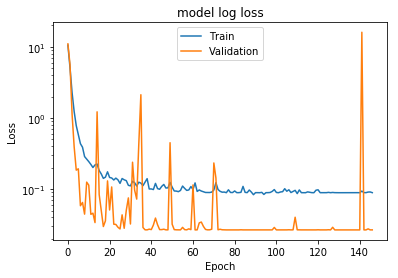

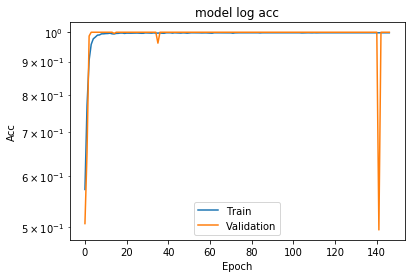

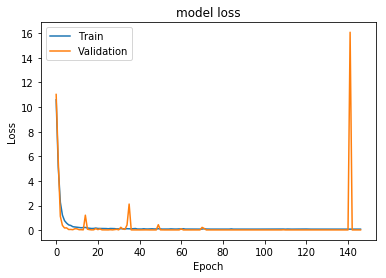

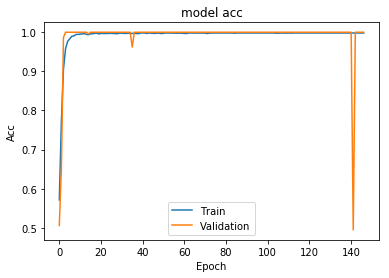

In [13]:
u.plot_loss(history, "model log loss","log")
u.plot_acc(history, "model log acc","log")

u.plot_loss(history, "model loss","linear")
u.plot_acc(history, "model acc","linear")

In [14]:
best_model= load_model('best_nbmodel_good_bad.hdf5',compile=False)

In [15]:
ypred=best_model.predict(Xtest)
ypredproba=best_model.predict_proba(Xtest)
#it's preferable to use .predict_classes because .predict might give probabilities 
#and not the label's in the case of multiclass
ypredclass=best_model.predict_classes(Xtest)

ypredclass=np.reshape(ypredclass,(ypredclass.shape[0],1))
#use argmax(1) to give the position of max value in a categorical variable like ytest
#it's basically a .predict_classes for ytest
ytestclass= ytest.argmax(1)
ytestclass=np.reshape(ytestclass,(ytestclass.shape[0],1))

Confusion matrix, without normalization
[[1209    2]
 [   0 1187]]
accuracy score:  0.999165971643


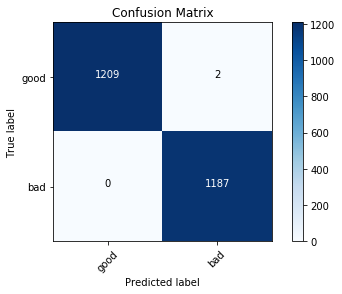

In [16]:
# from categorial to lable indexing


#yprednotcategorical =ypred.argmax(1)
#print ytestnotcategorical
#print yprednotcategorical
confusion= metrics.confusion_matrix(ytestclass,ypredclass)

plotlabels=['good','bad']
u.plot_confusion_matrix(confusion,plotlabels,title='Confusion Matrix')
print 'accuracy score: ',metrics.accuracy_score(ytestclass,ypredclass)

0.998351950702 For the label #0
0.998909184762 For the label #1


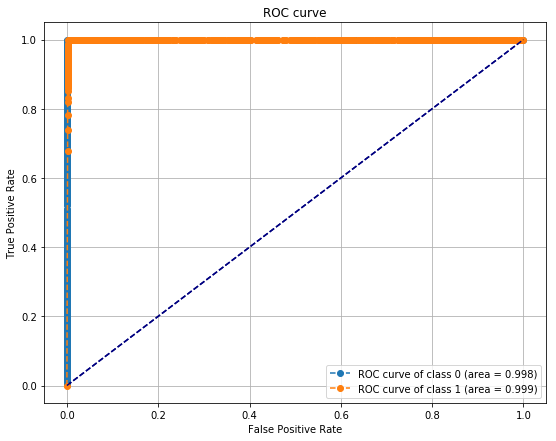

In [17]:
plt.figure(figsize=(9,7))
for i in range(ypredproba.shape[1]):
    fpr,tpr,thresholds= roc_curve(ytestclass,ypredproba[:,i],pos_label=i)
    roc_auc = auc(fpr, tpr)
    print roc_auc,'For the label #{0}'.format(i)

    plt.plot(fpr,tpr, linestyle='dashed'
             ,label='ROC curve of class {0} (area = {1:0.3f})' .format(i,roc_auc) ,marker='o')#% roc_auc, color='green'markerfacecolor='blue' ,markersize=4,
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--') 
    #plt.xlim([-.1,1.5])

    #plt.ylim([-0.1,1.5])    

    plt.title('ROC curve')

    plt.ylabel('True Positive Rate')

    plt.xlabel('False Positive Rate')

    plt.legend()

    plt.grid(True)
 

In [18]:
print Xtest.shape
for i in range(Xtest.shape[0]):
    samp = np.array([Xtest[i]])
    ypred = best_model.predict_classes(samp)
    if ypred[-1] == 0 and ytest[i][0] == 0:
        image = np.squeeze(Xtest,axis=3)[i]
        im=plt.imshow(image, cmap=cm.coolwarm)
        plt.colorbar()
        plt.show()
        plt.clf()
        print i
        for j in range(72):
            for k in range(32):
                if image[j][k] == 0.0:
                    a = (j,k)
                    print '0.0 at:', a
                if image[j][k] == 1.0:
                    b = (j,k)
                    print '1.0 at:',b

(2398, 72, 32, 1)


In [19]:
average_norm_occ = np.average(X)
std_norm_occ = np.std(X)

print 'mean:',average_norm_occ
print 'std:', std_norm_occ

mean: 0.416866321745
std: 0.193985217716
